In [ ]:
try:
 import art
except ModuleNotFoundError:
 !pip install adversarial-robustness-toolbox # module doesn't exist, deal with it.

In [ ]:
! pip show adversarial-robustness-toolbox

Name: adversarial-robustness-toolbox
Version: 1.11.0
Summary: Toolbox for adversarial machine learning.
Home-page: https://github.com/Trusted-AI/adversarial-robustness-toolbox
Author: Irina Nicolae
Author-email: irinutza.n@gmail.com
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: numba, scikit-learn, tqdm, six, scipy, numpy, setuptools
Required-by: 


# 1. Config the Environment

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import sys


print(f'python version: {sys.version}')
print(f'tensorflow version: {tf.__version__}')
print(f'keras version: {keras.__version__}')
print(f'numpy version: {np.__version__}')

python version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
tensorflow version: 2.8.2
keras version: 2.8.0
numpy version: 1.21.6


In [ ]:
tf.compat.v1.disable_eager_execution()

print(tf.executing_eagerly())

False


In [ ]:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion.carlini import CarliniL0Method, CarliniL2Method, CarliniLInfMethod

In [ ]:
# Load data and normalize
from art.utils import load_cifar10
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

min_pixel_value = 0
max_pixel_value = 1

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']

In [ ]:
# Select 10 and 100 random simple from Test set to test the algorithm
random_sample_10 = np.random.randint(low = 0, high = 10000, size = 10)
random_sample_10 = np.sort(random_sample_10).tolist()

random_sample_100 = np.random.randint(low = 0, high = 10000, size = 100)
random_sample_100 = np.sort(random_sample_100).tolist()

x_test_10 = x_test[random_sample_10, :]
x_test_100 = x_test[random_sample_100, :]

y_test_10 = y_test[random_sample_10, :]
y_test_100 = y_test[random_sample_100, :]


# 2. Test different model

## 2.1 Simple_CNN model attack

### 2.1 Config Simple CNN model

In [ ]:
!wget https://gitlab.act.reading.ac.uk/vo836354/msc_final_project_model/-/raw/main/saved_model/Simple_CNN/HDF5/Simple_CN.h5?inline=false -O Simple_CNN.h5

--2022-07-10 23:05:29--  https://gitlab.act.reading.ac.uk/vo836354/msc_final_project_model/-/raw/main/saved_model/Simple_CNN/HDF5/Simple_CN.h5?inline=false
Resolving gitlab.act.reading.ac.uk (gitlab.act.reading.ac.uk)... 134.225.116.8
Connecting to gitlab.act.reading.ac.uk (gitlab.act.reading.ac.uk)|134.225.116.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1575008 (1.5M) [application/octet-stream]
Saving to: ‘Simple_CNN.h5’

Simple_CNN.h5       100%[===================>]   1.50M  2.81MB/s    in 0.5s    

2022-07-10 23:05:30 (2.81 MB/s) - ‘Simple_CNN.h5’ saved [1575008/1575008]



In [ ]:
model = tf.keras.models.load_model('/content/Simple_CNN.h5', compile=False)

In [ ]:
model.compile(
    loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.01), metrics=["accuracy"]
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Create the ART classifier, pass the model to the ART classifier

classifier = KerasClassifier(model=model, clip_values=(min_, max_), use_logits=False)

In [ ]:
# Train the ART classifier

classifier.fit(x_train, y_train, batch_size=1024, nb_epochs=100)

In [ ]:
# Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy on benign test examples: 57.230000000000004%


### 2.1.2 Use random sample for attack

#### 2.1.2.1 C&W L0

In [ ]:
# Initialising the attacker
attack = CarliniL0Method(classifier=classifier)

###### 2.1.2.1.1 Use 10 samples for showing difference and effects

In [ ]:
x_test_adv = attack.generate(x=x_test_10)

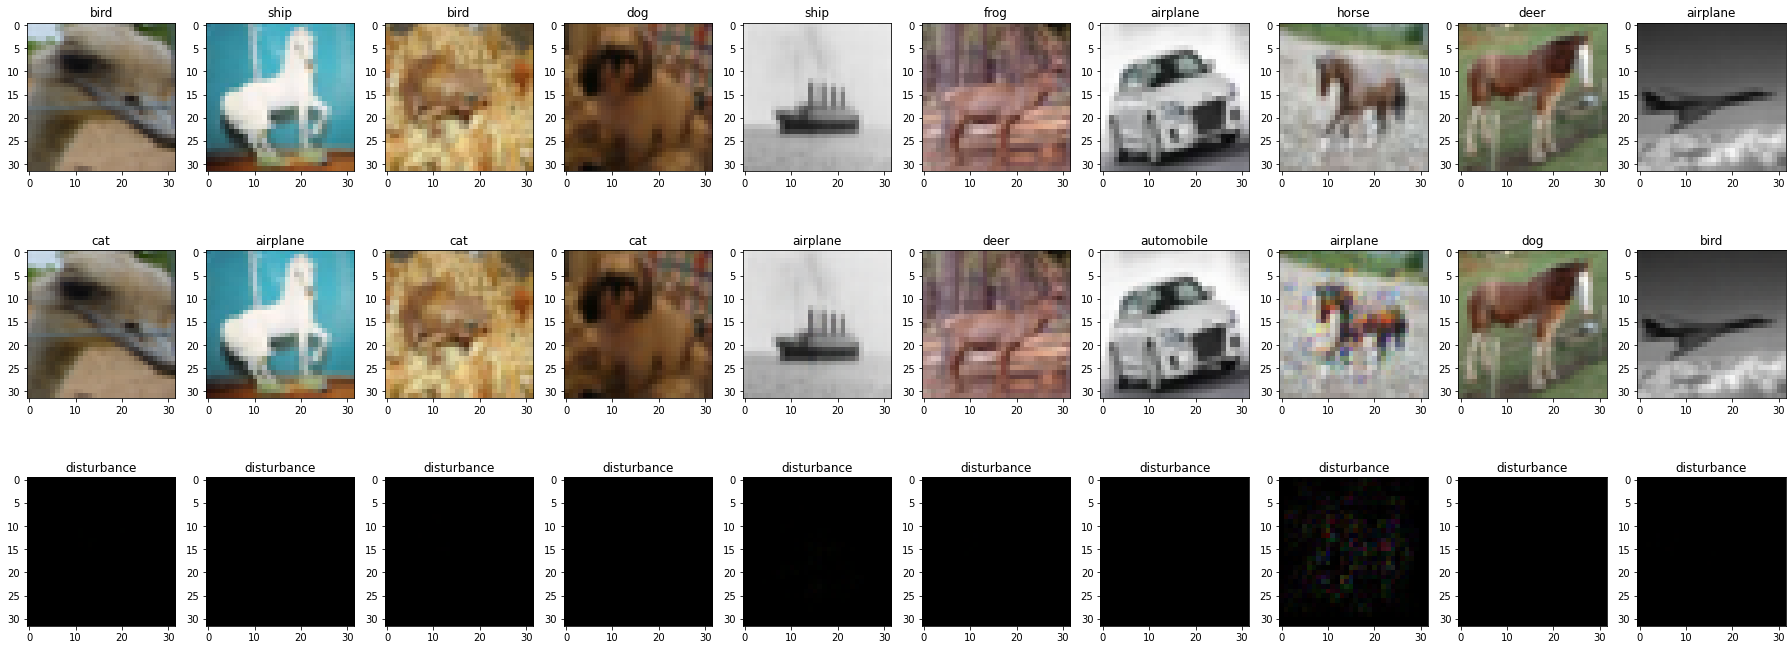

In [ ]:
fig, axs = plt.subplots(3, len(x_test_adv), figsize = (25, 10))

for i in range(len(x_test_adv)):
  axs[0, i].imshow(x_test_10[i])
  axs[1, i].imshow(x_test_adv[i])
  axs[2, i].imshow(np.abs(x_test_10[i] -  x_test_adv[i]))
  axs[0, i].set_title(label_names[np.argmax(classifier.predict(x_test_10[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[1, i].set_title(label_names[np.argmax(classifier.predict(x_test_adv[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[2, i].set_title('disturbance')
  fig.tight_layout()

##### 2.1.2.1.2 Test the effect of the attack with 100 random examples

In [ ]:
x_test_adv = attack.generate(x=x_test_100)

In [ ]:
# Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)

print(f'Total use \033[31m{len(x_test_adv)}\033[0m examples for testing')
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Total use 10 examples for testing
Accuracy on benign test examples: 0.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


#### 2.1.2.2 C&W L1

In [ ]:
# Initialising the attacker
attack = CarliniL2Method(classifier=classifier)

###### 2.1.2.1.1 Use 10 samples for showing difference and Effects

In [ ]:
x_test_adv = attack.generate(x=x_test_10)

C&W L_2:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
fig, axs = plt.subplots(3, len(x_test_adv), figsize = (25, 10))

for i in range(len(x_test_adv)):
  axs[0, i].imshow(x_test_10[i])
  axs[1, i].imshow(x_test_adv[i])
  axs[2, i].imshow(np.abs(x_test_10[i] -  x_test_adv[i]))
  axs[0, i].set_title(label_names[np.argmax(classifier.predict(x_test_10[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[1, i].set_title(label_names[np.argmax(classifier.predict(x_test_adv[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[2, i].set_title('disturbance')
  fig.tight_layout()

###### 2.1.2.1.2 Test the effect of the attack with 100 random examples

In [ ]:
x_test_adv = attack.generate(x=x_test_100)

C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)

print(f'Total use \033[31m{len(x_test_adv)}\033[0m examples for testing')
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Total use 100 examples for testing
Accuracy on benign test examples: 27.0%


#### 2.1.2.3 C&W Infinite

In [ ]:
# Initialising the attacker
attack = CarliniLInfMethod(classifier=classifier)

###### 2.1.2.1.1 Use 10 samples for showing difference and Effects

In [ ]:
x_test_adv = attack.generate(x=x_test_10)

C&W L_inf:   0%|          | 0/10 [00:00<?, ?it/s]

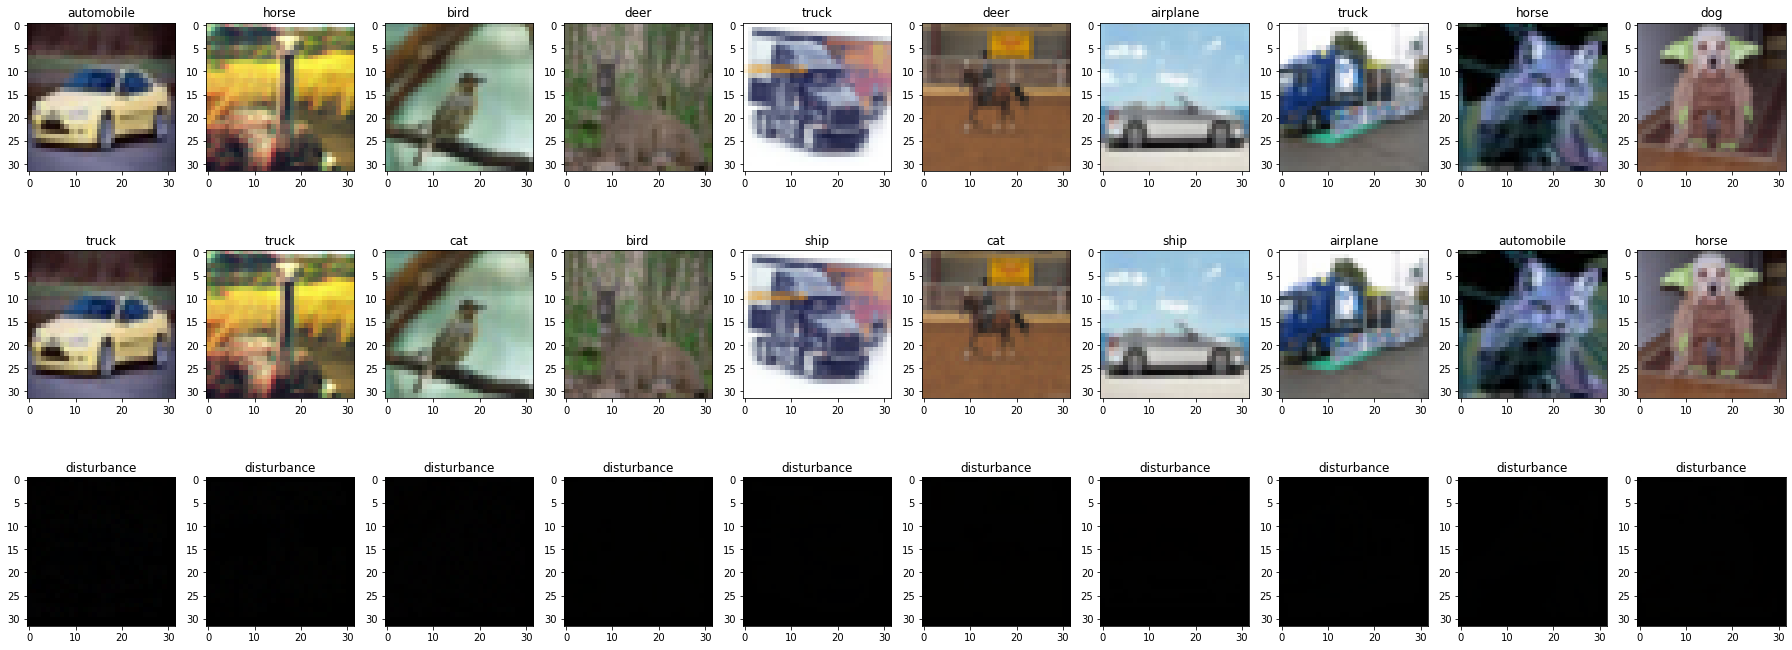

In [ ]:
fig, axs = plt.subplots(3, len(x_test_adv), figsize = (25, 10))

for i in range(len(x_test_adv)):
  axs[0, i].imshow(x_test_10[i])
  axs[1, i].imshow(x_test_adv[i])
  axs[2, i].imshow(np.abs(x_test_10[i] -  x_test_adv[i]))
  axs[0, i].set_title(label_names[np.argmax(classifier.predict(x_test_10[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[1, i].set_title(label_names[np.argmax(classifier.predict(x_test_adv[i].reshape(1, 32, 32, 3)), axis=1)[0]])
  axs[2, i].set_title('disturbance')
  fig.tight_layout()

###### 2.1.2.1.2 Test the effect of the attack with 100 random examples

In [ ]:
x_test_adv = attack.generate(x=x_test_100)

C&W L_inf:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_100, axis=1)) / len(y_test_100)

print(f'Total use \033[31m{len(x_test_adv)}\033[0m examples for testing')
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Total use 100 examples for testing
Accuracy on benign test examples: 27.0%
